
The SEM dataset is composed of a training and a validation images acquired on a scanning 
electron microscopy (SEM). They were originally used in Buchholtz et al (2019) to showcase
CARE denoising. Here, we demonstrate the performances of Noise2Noise on this particular dataset!

In [16]:
# Imports necessary to execute the code
from pathlib import Path

import matplotlib.pyplot as plt
import tifffile
from careamics import CAREamist
from careamics.config import create_n2n_configuration
from careamics.utils.metrics import psnr
from careamics_portfolio import PortfolioManager

## Import the dataset

The dataset can be directly downloaded using the `careamics-portfolio` package, which
uses `pooch` to download the data.

The N2N SEM dataset consists of EM images with 7 different levels of noise:

- Image 0 is recorded with 0.2 us scan time
- Image 1 is recorded with 0.5 us scan time
- Image 2 is recorded with 1 us scan time
- Image 3 is recorded with 1 us scan time
- Image 4 is recorded with 2.1 us scan time
- Image 5 is recorded with 5.0 us scan time
- Image 6 is recorded with 5.0 us scan time and is the avg. of 4 images


In [12]:
# instantiate data portfolio manage
portfolio = PortfolioManager()

# and download the data
root_path = Path("./data")
download = portfolio.denoising.N2N_SEM.download(root_path)
files = [f for f in download if f.endswith("tif")]
files.sort()

## Visualize data

Text(0.5, 1.0, 'Target crop (1 us)')

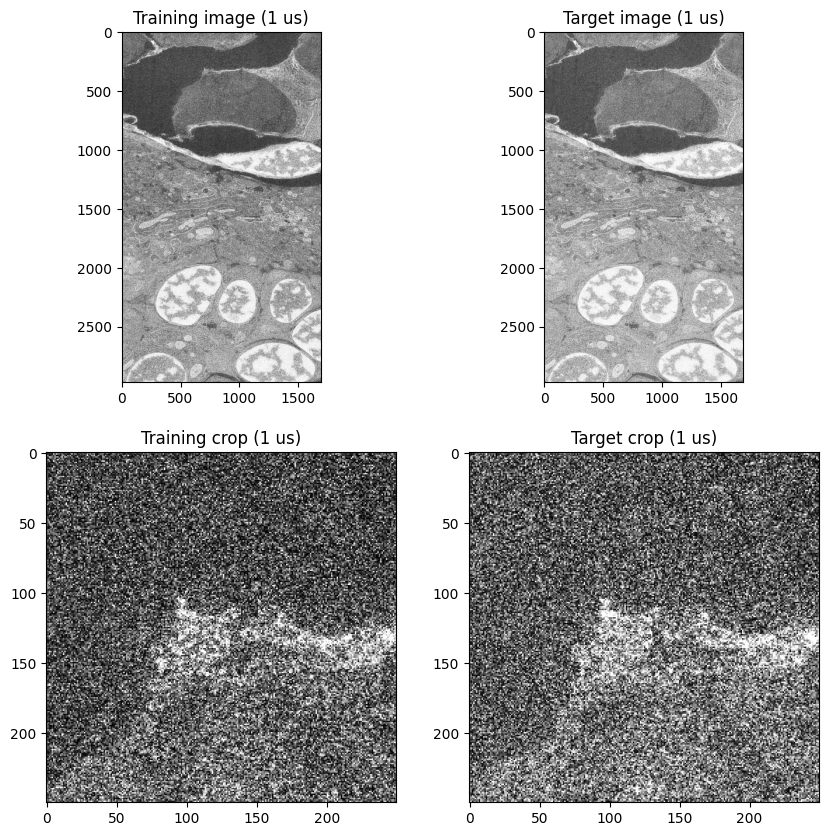

In [13]:
# load training and validation image and show them side by side
train_stack = tifffile.imread(files[1])

# use the 1 us scan time to perform Noise2Noise
train_image = train_stack[2]
train_target = train_stack[3]

# plot the two images and a crop
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].set_title("Training image (1 us)")

ax[0, 1].imshow(train_target, cmap="gray")
ax[0, 1].set_title("Target image (1 us)")

x_start, x_end = 600, 850
y_start, y_end = 200, 450
ax[1, 0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 0].set_title("Training crop (1 us)")

ax[1, 1].imshow(train_target[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 1].set_title("Target crop (1 us)")

## Train with CAREamics

The easiest way to use CAREamics is to create a configuration and a `CAREamist`. 

### Create configuration

The configuration can be built from scratch, giving the user full control over the various
parameters available in CAREamics. However, a straightforward way to create a configuration
for a particular algorithm is to use one of the convenience functions.

In [23]:
config = create_n2n_configuration(
    experiment_name="sem_n2n",
    data_type="array",
    axes="YX",
    patch_size=(64, 64),
    batch_size=64,
    num_epochs=50,
)

print(config)

{'algorithm_config': {'algorithm': 'n2n',
                      'loss': 'mae',
                      'lr_scheduler': {'name': 'ReduceLROnPlateau',
                                       'parameters': {}},
                      'model': {'architecture': 'UNet',
                                'conv_dims': 2,
                                'depth': 2,
                                'final_activation': 'None',
                                'in_channels': 1,
                                'independent_channels': False,
                                'n2v2': False,
                                'num_channels_init': 32,
                                'num_classes': 1},
                      'optimizer': {'name': 'Adam',
                                    'parameters': {'lr': 0.0001}}},
 'data_config': {'axes': 'YX',
                 'batch_size': 64,
                 'data_type': 'array',
                 'patch_size': [64, 64],
                 'transforms': [{'mean': 0.485,
     

### Train

A `CAREamist` can be created using a configuration alone, and then be trained by using
the data already loaded in memory.

In [24]:
# instantiate a CAREamist
careamist = CAREamist(source=config)

# train
careamist.train(
    train_source=train_image,
    train_target=train_target,
    val_minimum_split=5,
)

No working directory provided. Using current working directory: /home/joran.deschamps/git/careamics/careamics-examples/applications/n2n.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Extracted 1269 patches from input array.
Computed dataset mean: 37102.1484375, std: 19112.2578125
/localscratch/miniforge3/envs/02_regression/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/joran.deschamps/git/careamics/careamics-examples/applications/n2n/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 509 K 
-------------------------------
509 K     Trainable params
0         Non-trainable params
509 K     Total params
2.037     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 24.06it/s, train_loss_step=0.722]
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 24.94it/s, train_loss_step=0.668, val_loss=0.793, train_loss_epoch=0.823]
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 23.75it/s, train_loss_step=0.638, val_loss=0.698, train_loss_epoch=0.727]
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 23.89it/s, train_loss_step=0.627, val_loss=0.667, train_loss_epoch=0.678]
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████████████████████████████████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 19.57it/s, train_loss_step=0.602, val_loss=0.592, train_loss_epoch=0.596]


## Predict with CAREamics

Prediction is done with the same `CAREamist` used for training. Because the image is large
we predict using tiling.

In [21]:
prediction = careamist.predict(source=train_image, tile_size=(256, 256))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/localscratch/miniforge3/envs/02_regression/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

### Visualize the prediction

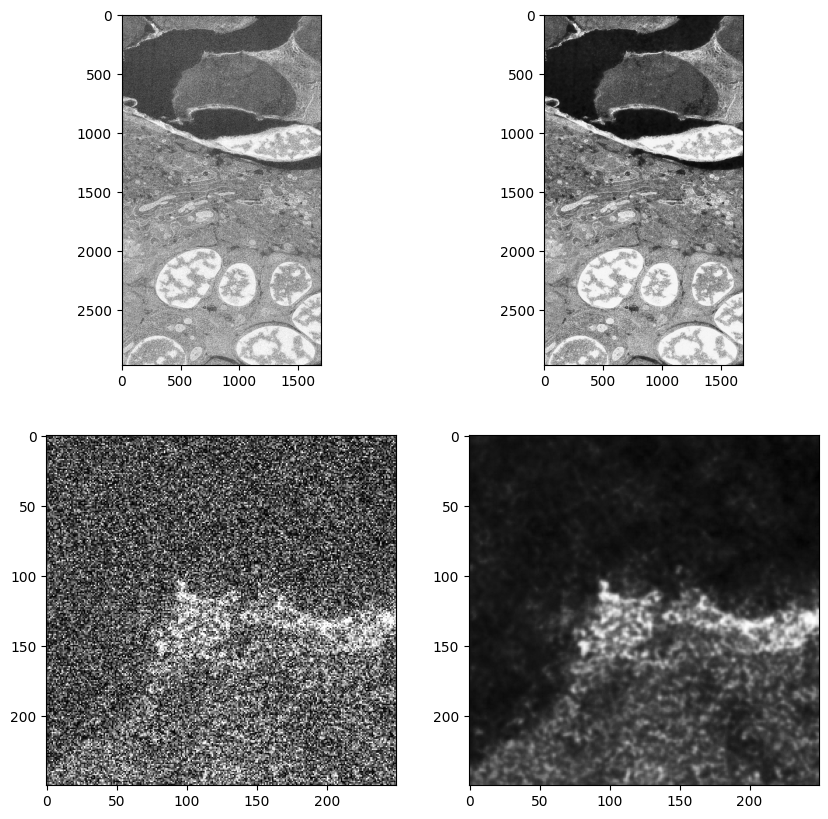

In [22]:
# get pseudo ground-truth from the 5 us averaged scan time
pseudo_gt = train_stack[-1]
psnr_noisy = psnr(pseudo_gt, train_image)
psnr_pred = psnr(pseudo_gt, prediction.squeeze())

# Show the full image and crops
x_start, x_end = 600, 850
y_start, y_end = 200, 450

fig, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].imshow(train_image, cmap="gray")
ax[0, 0].title.set_text(f"Training image (1 us)\nPSNR: {psnr_noisy:.2f}")

ax[0, 1].imshow(prediction.squeeze(), cmap="gray")
ax[0, 1].title.set_text(f"Prediction (1 us)\nPSNR: {psnr_pred:.2f}")

ax[0, 2].imshow(pseudo_gt, cmap="gray")
ax[0, 2].title.set_text("Pseudo GT (5 us averaged)")

ax[1, 0].imshow(train_image[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 1].imshow(prediction.squeeze()[y_start:y_end, x_start:x_end], cmap="gray")
ax[1, 2].imshow(pseudo_gt[y_start:y_end, x_start:x_end], cmap="gray")